In [20]:
import numpy as np
import jax.numpy as jnp
from jax import random, jit, jacfwd, jacrev, vmap
from jax.numpy.linalg import inv
from jax.nn import tanh, sigmoid, relu

from scipy.optimize import minimize
from scipy.stats import norm

import matplotlib.pyplot as plt

np.random.seed(12345)

In [2]:
# generate data 
n = 21
f = lambda x: .7*np.sin(5 * x) * (1 - np.tanh(x ** 2))

# precision of prior
alpha = 1.

# precision of noise
s = .2
beta = 1./s**2

x = np.linspace(-1., 1., n)
t = f(x) + s * np.random.randn(n) 

In [3]:
# analytical posterior 
basis = lambda x: jnp.array([1., x, x**2, x**3, x**4, x**5, x**6, x**7])
Phi = vmap(basis)(x)

# Hessian 
Sinv = alpha*np.eye(Phi.shape[1]) + beta * Phi.T @ Phi 
# Covariance
S = np.linalg.inv(Sinv)
# Mean 
m = beta * S @ Phi.T @ t

In [4]:
# posterior predictive distribution 
x_eval = np.linspace(-1.2, 1.2, 100)
Phi = vmap(basis)(x_eval)
t_hat_true = Phi@m
s_hat_true = np.sqrt(np.einsum('ni,ij,nj->n', Phi, S, Phi))

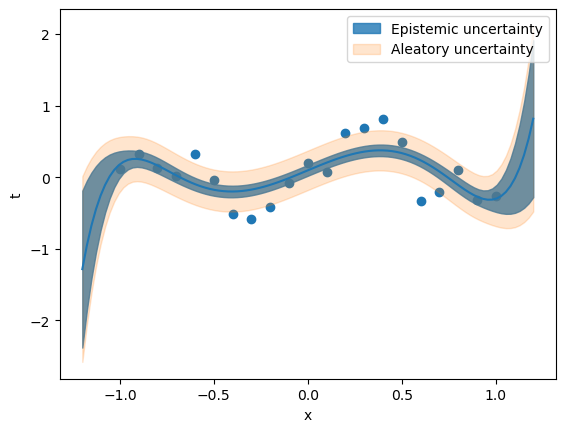

In [5]:
plt.scatter(x, t)
plt.plot(x_eval, t_hat_true)
plt.fill_between(x_eval, t_hat_true-s_hat_true, t_hat_true+s_hat_true, alpha=.8, color='C0', 
                 label='Epistemic uncertainty')
plt.fill_between(x_eval, t_hat_true-(s+s_hat_true), t_hat_true+s+s_hat_true, alpha=.2, color='C1', 
                 label='Aleatory uncertainty')
plt.legend()
plt.xlabel("x")
plt.ylabel("t")
plt.show()

In [6]:
# goal is to use a neural network to map Gaussian noise to samples from posterior parameter distribution

In [7]:
# define model that takes in unknown parameters (latent variables)
@jit
def model(x, z):
    
    a, b, c, d, e, f, g, h = z
    
    return a + b*x + c*x**2 + d*x**3 + e*x**4 + f*x**5 + g*x**6 + h*x**7

# gradient of model w.r.t. parameters
grad_model = jit(jacfwd(model, 1))

# problem dimension
d = 8

# hidden dimension of NN (weird things happen when h < d)
h = 10

# determine shapes of weights/biases = [Wih, bih, Who, bho]
shapes = [[h, d], [h], [d, h], [d]]
k_params = []
n_params = 0
for shape in shapes:
    k_params.append(n_params)
    n_params += np.prod(shape)
k_params.append(n_params)

# initialize parameters
lmbda = np.zeros(n_params)
for k1,k2,shape in zip(k_params, k_params[1:], shapes):
    if len(shape)>1:
        stdv = 1./shape[-1] # np.sqrt(shape[-1])
    lmbda[k1:k2] = stdv*np.random.randn(k2-k1,)

# reshape parameters into weight matrices and bias vectors
def reshape(params):
    # params is a vector = [Wih, bih, Who, bho]
    return [np.reshape(params[k1:k2], shape) for k1, k2, shape in
            zip(k_params, k_params[1:], shapes)]

@jit
def nn(y, lmbda):
    
    # weights and biases of nn
    W1, b1, W2, b2 = reshape(lmbda)
    
    # hidden layer
    h = tanh(jnp.einsum('ij,...j->...i', W1, y) + b1)
    
    # output
    z = jnp.einsum('ij,...j->...i', W2, h) + b2
    
    return z

# gradient of nn output w.r.t. parameters
grad_nn = jit(jacfwd(nn, 1))
    
# gradient of nn output w.r.t. parameters
jac_nn = jit(jacfwd(nn, 0))

# log of absolute value of determinant of Jacobian of neural network
@jit
def log_det(yi, lmbda):
    # return jnp.log(jnp.abs(jnp.linalg.det(jac_nn(yi, lmbda))))
    return jnp.sum(jnp.log(jnp.abs(jnp.linalg.eigvals(jac_nn(yi, lmbda)))))

# gradient of log abs det w.r.t. neural network parameters
grad_log_det = jit(jacrev(log_det, 1))

# evaluate log_det in batches
batch_log_det = jit(vmap(log_det, (0, None)))

# gradient of entropy of approximating distribution w.r.t. lmbda
batch_grad_log_det = jit(jacrev(batch_log_det, 1))

# evaluate log (likelihood * prior)
@jit
def log_posterior(y, lmbda):
    # map to sample from posterior
    z = nn(y, lmbda)
    # likelihood
    lp = beta * jnp.sum((t - model(x, z))**2) / 2. 
    # prior
    lp += alpha * jnp.sum(z**2) / 2. 
    return lp

# gradient of log posterior
grad_log_posterior = jit(jacrev(log_posterior, 1))

# eval log posterior in batches 
batch_log_posterior = jit(vmap(log_posterior, (0, None)))

# gradient of log posterior
batch_grad_log_posterior = jit(jacrev(batch_log_posterior, 1))

In [8]:
y = np.random.randn(d)

In [9]:
%timeit grad_log_det(y, lmbda)

59.3 µs ± 19.8 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%timeit grad_log_posterior(y, lmbda)

13.8 µs ± 6.17 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Future steps toward improving tractability as problems get more complicated will be implementation of neural network architectures that the simplify the determinant computation. Examples include planar flow and autoregressive architectures.  

In [11]:
# ELBO cost function 
def elbo(lmbda, n_sample=10):
    
    # use nn to sample parameters
    y = np.random.randn(n_sample, d)
    
    # evaluate model fitness 
    ELBO = np.mean(batch_log_posterior(y, lmbda), 0)
    ELBO -= np.mean(batch_log_det(y, lmbda), 0)
    
    return ELBO

# gradient of ELBO cost function
def grad_elbo(lmbda, n_sample=10):
    
    # use nn to sample parameters
    y = np.random.randn(n_sample, d)
    
    # gradient 
    grad_ELBO = np.mean(batch_grad_log_posterior(y, lmbda), 0)
    grad_ELBO -= np.mean(batch_grad_log_det(y, lmbda), 0)
    
    return grad_ELBO

In [12]:
# adam from chat gpt
def adam_optimizer(f, grad_f, initial_params, learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8, max_iterations=1000, tol=1e-6):
    """
    ADAM optimizer for minimizing a function.

    Parameters:
    - grad_f: Gradient function that returns the gradient of the objective function.
    - initial_params: Initial guess for the parameters.
    - learning_rate: Step size for the optimization (default: 0.001).
    - beta1: Exponential decay rate for the first moment estimate (default: 0.9).
    - beta2: Exponential decay rate for the second moment estimate (default: 0.999).
    - epsilon: Small constant to prevent division by zero (default: 1e-8).
    - max_iterations: Maximum number of iterations (default: 1000).
    - tol: Tolerance to stop optimization when the change in parameters is below this value (default: 1e-6).

    Returns:
    - Optimal parameters.
    """
    params = initial_params
    m = np.zeros_like(params)
    v = np.zeros_like(params)
    t = 0

    while t < max_iterations:
        t += 1
        
        if t%10==0:
            print("ELBO: {:.3f}".format(elbo(params, n_sample=10)))

        gradient = np.nan_to_num(grad_f(params))
        
        
        m = beta1 * m + (1 - beta1) * gradient
        v = beta2 * v + (1 - beta2) * (gradient ** 2)

        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)

        params -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)

        if np.linalg.norm(learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)) < tol:
            break

    return params

In [13]:
# optimize nn parameters
lmbda = adam_optimizer(elbo, grad_elbo, lmbda)

ELBO: 58.084
ELBO: 54.535
ELBO: 52.428
ELBO: 50.743
ELBO: 48.129
ELBO: 48.522
ELBO: 48.681
ELBO: 47.014
ELBO: 47.456
ELBO: 45.936
ELBO: 45.329
ELBO: 44.962
ELBO: 44.259
ELBO: 44.656
ELBO: 43.256
ELBO: 41.951
ELBO: 42.513
ELBO: 42.717
ELBO: 41.732
ELBO: 42.174
ELBO: 40.328
ELBO: 40.581
ELBO: 39.943
ELBO: 42.171
ELBO: 40.940
ELBO: 41.404
ELBO: 39.997
ELBO: 39.965
ELBO: 39.615
ELBO: 41.334
ELBO: 40.381
ELBO: 40.108
ELBO: 40.758
ELBO: 38.105
ELBO: 40.072
ELBO: 37.971
ELBO: 39.827
ELBO: 38.639
ELBO: 39.697
ELBO: 40.063
ELBO: 39.071
ELBO: 39.137
ELBO: 39.499
ELBO: 38.577
ELBO: 38.274
ELBO: 38.449
ELBO: 39.348
ELBO: 38.390
ELBO: 39.005
ELBO: 40.557
ELBO: 37.961
ELBO: 39.361
ELBO: 38.696
ELBO: 39.659
ELBO: 39.473
ELBO: 38.796
ELBO: 39.915
ELBO: 39.007
ELBO: 40.099
ELBO: 39.106
ELBO: 37.760
ELBO: 39.348
ELBO: 39.303
ELBO: 38.591
ELBO: 40.671
ELBO: 39.445
ELBO: 39.832
ELBO: 39.597
ELBO: 38.709
ELBO: 38.213
ELBO: 39.100
ELBO: 39.310
ELBO: 39.083
ELBO: 39.499
ELBO: 40.490
ELBO: 39.508
ELBO: 39.813

In [14]:
# sample noise
# y = np.random.random(size=[1000, d])
y = np.random.randn(1000, d)
z = nn(y, lmbda)

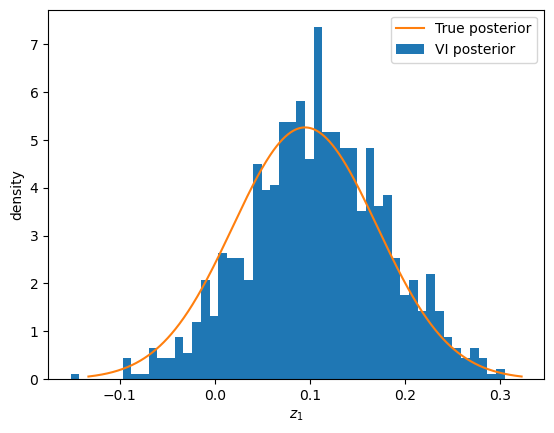

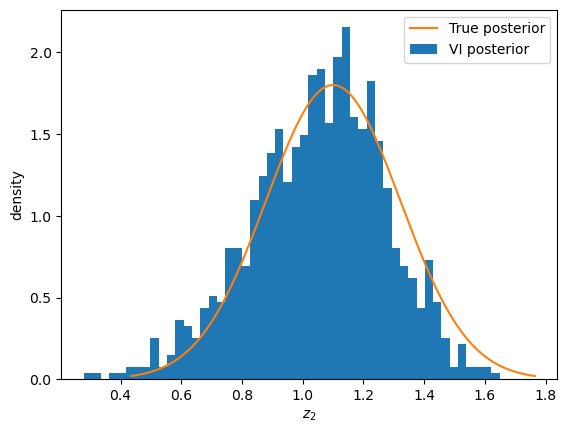

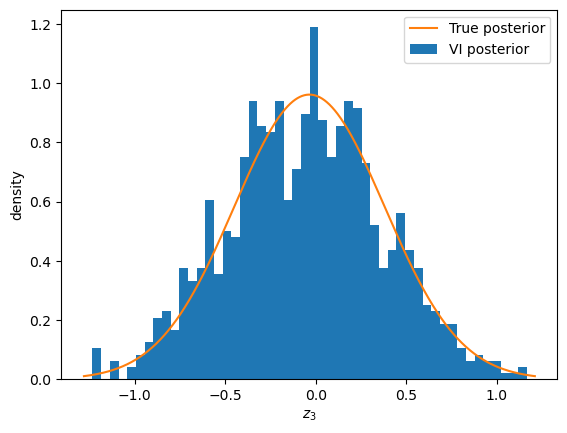

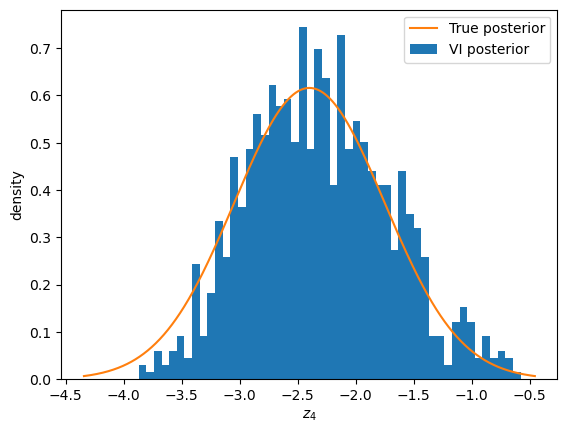

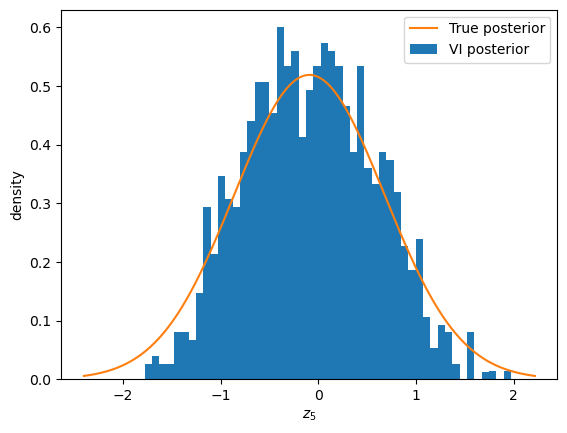

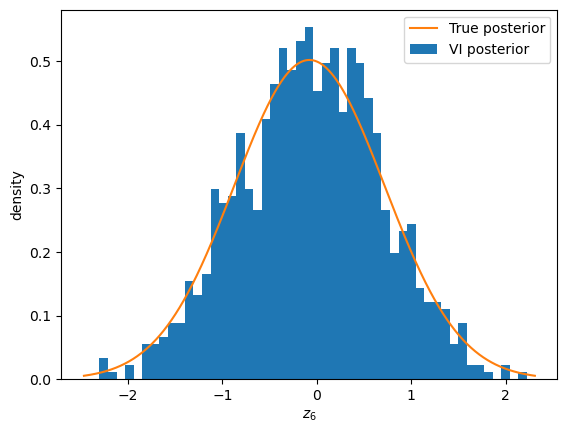

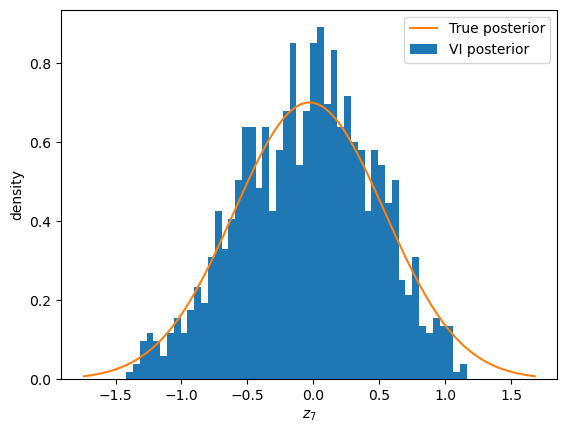

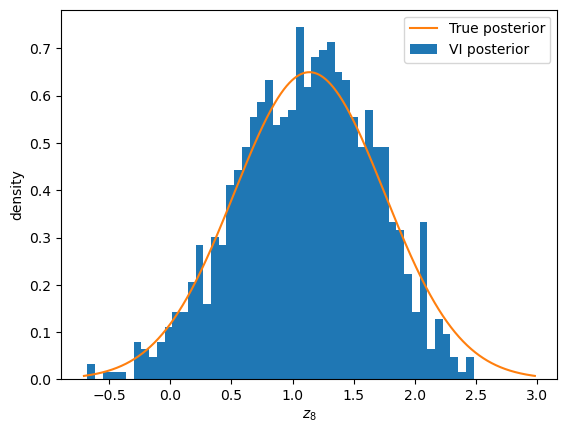

In [15]:
for i, (mean, variance) in enumerate(zip(m, np.diag(S))):

    # Generate data points for x-axis
    x_vals = np.linspace(mean - 3 * np.sqrt(variance), mean + 3 * np.sqrt(variance), 1000)

    # Calculate the corresponding probability density function (PDF) values
    pdf_values = norm.pdf(x_vals, mean, np.sqrt(variance))
    plt.plot(x_vals, pdf_values, c='C1', label='True posterior')
    
    # plot NN posterior 
    plt.hist(np.array(z[:, i]), color='C0', bins=50, density=True, label='VI posterior')
    
    plt.xlabel(f"$z_{i+1}$")
    plt.ylabel("density")
    plt.legend()
    plt.show()

In [16]:
# plot posterior predictive 
t_samples = vmap(model, (None, 0))(x_eval, z)
t_hat = np.mean(t_samples, 0)
s_hat = np.std(t_samples, 0)

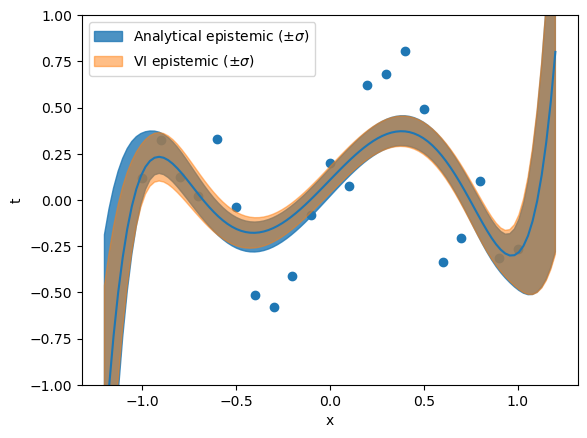

In [19]:
plt.scatter(x, t)
plt.plot(x_eval, t_hat)
plt.fill_between(x_eval, t_hat_true-s_hat_true, t_hat_true+s_hat_true, alpha=.8, color='C0', 
                 label='Analytical epistemic ($\pm \sigma$)')
plt.fill_between(x_eval, t_hat-s_hat, t_hat+s_hat, alpha=.5, color='C1', label='VI epistemic ($\pm \sigma$)')
plt.xlabel("x")
plt.ylabel("t")
plt.legend(loc='upper left')
plt.ylim([-1, 1])
plt.savefig("figures/linear_regression.png")
plt.show()